<a href="https://colab.research.google.com/github/miltiadiss/Lung-cancer-classification-from-CT-images-using-explainbility-techniques/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Method 1: CNN on preprocessed images**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load neccesary packages

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import cv2
from lime import lime_image
from skimage.segmentation import mark_boundaries

Load training, validation and test sets

In [2]:
training_data = np.load("drive/MyDrive/train.npz")
X_train = training_data["X"]
y_train = training_data["y"]

validation_data = np.load("drive/MyDrive/val.npz")
X_val = validation_data["X"]
y_val = validation_data["y"]

test_data = np.load("drive/MyDrive/test.npz")
X_test = test_data["X"]
y_test = test_data["y"]

Build CNN architecture

In [3]:
def build_cnn(input_shape=(256,256,1), num_classes=3):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


model = build_cnn(input_shape=(256,256,1), num_classes=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,838,787 (56.61 MB)

 Trainable params: 14,838,787 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

Train for 30 epochs using Early Stopping

In [4]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('drive/MyDrive/best_cnn_model.keras', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.4350 - loss: 1.0848 - val_accuracy: 0.4848 - val_loss: 0.9270
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.6186 - loss: 0.8628 - val_accuracy: 0.7818 - val_loss: 0.6906
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.7564 - loss: 0.6235 - val_accuracy: 0.8424 - val_loss: 0.4268
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.8649 - loss: 0.3816 - val_accuracy: 0.9091 - val_loss: 0.2359
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 174s 5s/step - accuracy: 0.9215 - loss: 0.2475 - val_accuracy: 0.9576 - val_loss: 0.1617
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.9702 - loss: 0.1371 - val_accuracy: 0.9576 - val_loss: 0.1717
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.9821 - loss: 0.0931 - val_accuracy: 0.9818 - val_loss: 0.0796
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - accuracy: 0.9881 - loss: 0.0653 - val_accuracy: 0.9758 - v

Plot learning curves for train, val sets

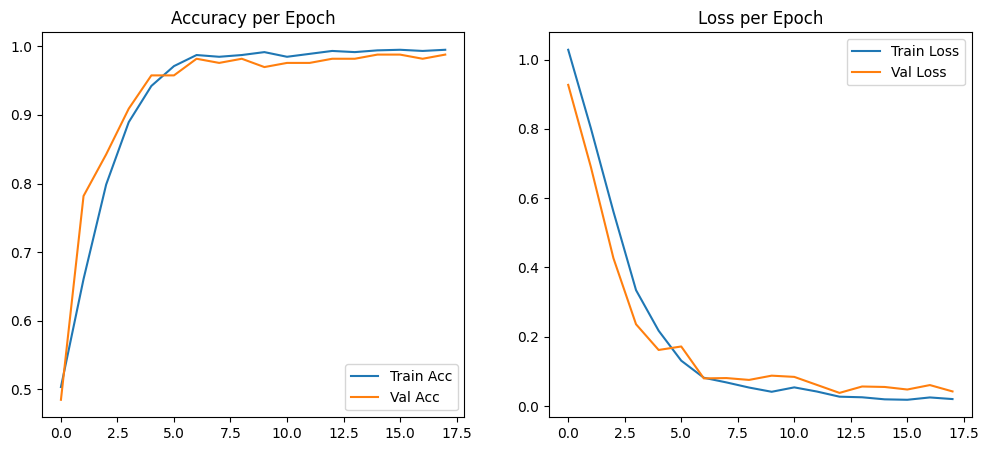

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()


Evaluate on test set and plot classification report, confusion matrix, ROC curves

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
              precision    recall  f1-score   support

      Benign       1.00      0.83      0.91        18
      Normal       0.97      1.00      0.98        85
   Malignant       0.95      0.95      0.95        62

    accuracy                           0.96       165
   macro avg       0.97      0.93      0.95       165
weighted avg       0.96      0.96      0.96       165



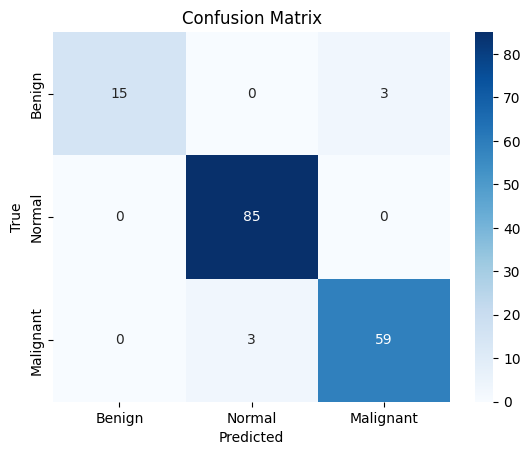

In [6]:
class_mapping = {
  'Benign': 0,
  'Normal': 1,
  'Malignant': 2
}

y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred, target_names=class_mapping.keys()))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping.keys(),
            yticklabels=class_mapping.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


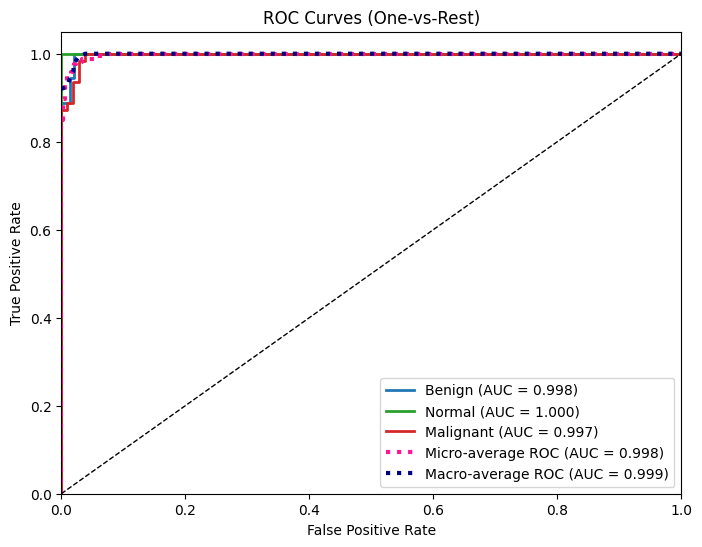

In [8]:
y_pred_proba = model.predict(X_test)   # Get softmax probabilities
y_pred = np.argmax(y_pred_proba, axis=1)

# Label one-hot encoding
n_classes = len(class_mapping)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 6))

colors = ['#1f77b4', '#2ca02c', '#d62728']
for i, (cls, color) in enumerate(zip(class_mapping.keys(), colors)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{cls} (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=3)
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.3f})',
         color='navy', linestyle=':', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

Apply the different explainability methods on an instance of test set

**Grad-CAM**

Ground truth: Malignant (2)
Prediction: Malignant (2)
Confidence: 99.62%

Probabilities:
  Benign: 0.34%
  Normal: 0.04%
  Malignant: 99.62%


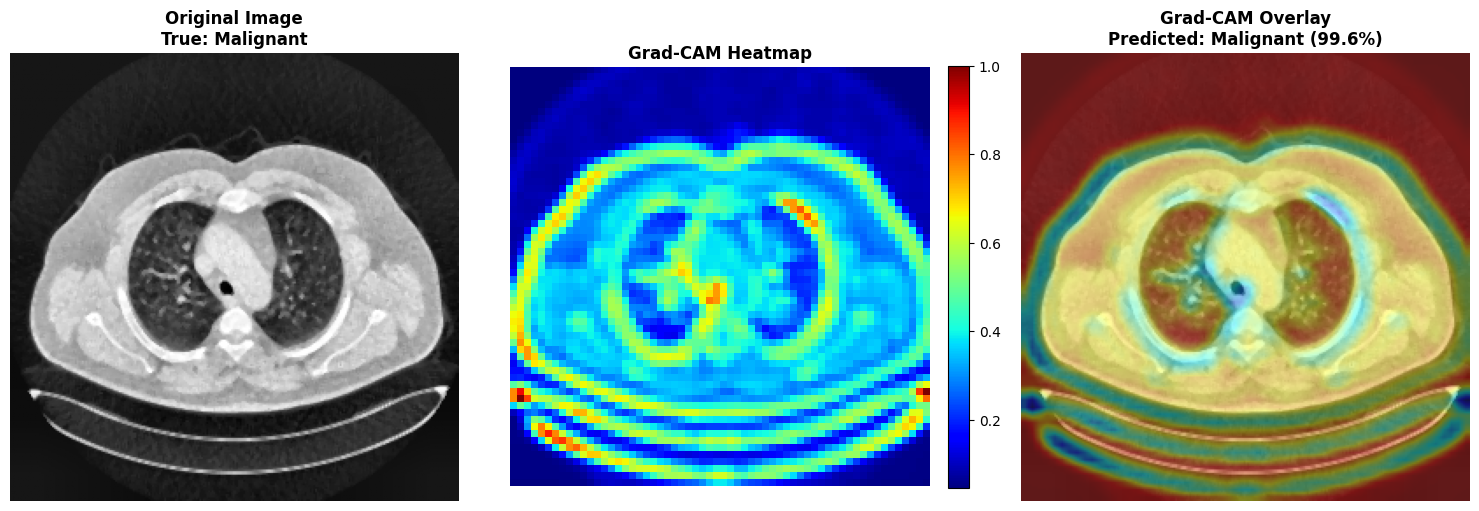

In [12]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Last conv layer index
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Conv layer outputs
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Conv outputs --> predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input

    # Add all the layers after last conv layer
    found_conv = False
    for layer in model.layers:
        if layer.name == last_conv_layer_name:
            found_conv = True
            continue
        if found_conv:
            x = layer(x)

    classifier_model = tf.keras.Model(classifier_input, x)

    # Calculate gradients
    with tf.GradientTape() as tape:
        # Get conv outputs
        conv_outputs = last_conv_layer_model(img_array)
        tape.watch(conv_outputs)

        # Get predictions
        predictions = classifier_model(conv_outputs)

        if pred_index is None:
            pred_index = tf.argmax(predictions[0])

        class_channel = predictions[:, pred_index]

    # Output neuron gradient from conv layer output
    grads = tape.gradient(class_channel, conv_outputs)

    # Gradients global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel with corresponding gradient
    conv_outputs = conv_outputs[0]
    pooled_grads = pooled_grads.numpy()
    conv_outputs = conv_outputs.numpy()

    for i in range(pooled_grads.shape[0]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # Mean across all channels
    heatmap = np.mean(conv_outputs, axis=-1)

    # ReLUand normalization
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap = heatmap / np.max(heatmap)

    return heatmap


def overlay_heatmap_on_image(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    # Resize heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB with colormap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)

    # Convert grayscale to RGB
    img_rgb = cv2.cvtColor(np.uint8(255 * img), cv2.COLOR_GRAY2RGB)

    # Overlay
    superimposed_img = cv2.addWeighted(img_rgb, 1 - alpha, heatmap, alpha, 0)

    return superimposed_img

# Get last convolutional layer from trained model
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

# Choose a random test image
idx = np.random.randint(0, len(X_test))
test_img = X_test[idx]
true_label = y_test[idx]

# Make prediction
img_array = np.expand_dims(test_img, axis=0)
predictions = model.predict(img_array, verbose=0)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

class_names = {v: k for k, v in class_mapping.items()}

print(f"Ground truth: {class_names[true_label]} ({true_label})")
print(f"Prediction: {class_names[predicted_class]} ({predicted_class})")
print(f"Confidence: {confidence:.2%}")
print(f"\nProbabilities:")
for i, prob in enumerate(predictions[0]):
    print(f"  {class_names[i]}: {prob:.2%}")

# Create Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

original_img = test_img.squeeze()
superimposed = overlay_heatmap_on_image(original_img, heatmap)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_img, cmap='gray')
axes[0].set_title(f'Original Image\nTrue: {class_names[true_label]}', fontsize=12, fontweight='bold')
axes[0].axis('off')

im = axes[1].imshow(heatmap, cmap='jet')
axes[1].set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

axes[2].imshow(superimposed)
axes[2].set_title(f'Grad-CAM Overlay\nPredicted: {class_names[predicted_class]} ({confidence:.1%})',
                  fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

**LIME**

  0%|          | 0/1000 [00:00<?, ?it/s]

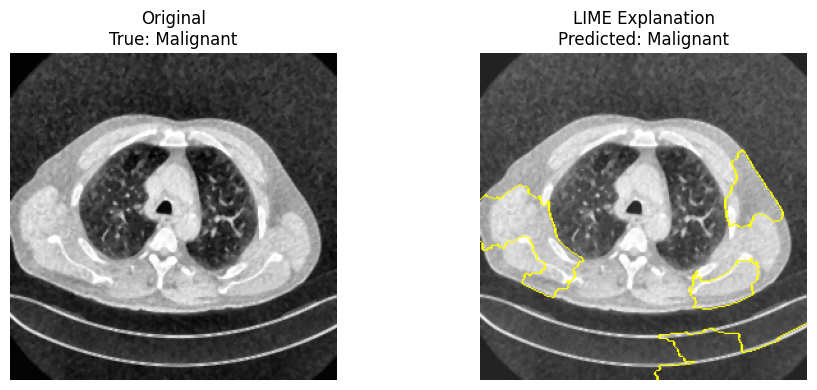

In [16]:
def predict_fn(images):
    processed = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    processed = processed[..., np.newaxis] / 255.0
    return model.predict(processed, verbose=0)

# Choose a random test image
idx = np.random.randint(0, len(X_test))
img = X_test[idx]
true_label = y_test[idx]
class_names = {v: k for k, v in class_mapping.items()}

# Convert grayscale to RGB for LIME
img_rgb = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

# Create explainer
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image=img_rgb,
    classifier_fn=predict_fn,
    top_labels=3,
    hide_color=0,
    num_samples=1000
)

pred_class = np.argmax(model.predict(np.expand_dims(img, axis=0), verbose=0)[0])
temp, mask = explanation.get_image_and_mask(
    label=pred_class,
    positive_only=True,
    num_features=5,
    hide_rest=False
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(img.squeeze(), cmap='gray')
axes[0].set_title(f"Original\nTrue: {class_names[true_label]}")
axes[0].axis('off')

axes[1].imshow(mark_boundaries(temp / 255.0, mask))
axes[1].set_title(f"LIME Explanation\nPredicted: {class_names[pred_class]}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
!pip install streamlit pyngrok opencv-python-headless pillow matplotlib tensorflow


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image
import pandas as pd
import plotly.express as px
from io import BytesIO

# === Βασικές ρυθμίσεις σελίδας ===
st.set_page_config(page_title="Lung Cancer CNN + Grad-CAM", layout="wide")

# === Πληροφορίες στην sidebar ===
st.sidebar.title("🩺 About this App")
st.sidebar.markdown("""
**Lung Cancer Detection Platform**

This tool uses a trained **Convolutional Neural Network (CNN)** model to analyze **lung CT scans**.

- 🟢 **Benign:** Non-cancerous tissue
- ⚪ **Normal:** Healthy lung
- 🔴 **Malignant:** Cancerous tissue

The **Grad-CAM** visualization highlights the most influential regions for the model’s decision.
""")
st.sidebar.info("Upload a CT image (JPG or PNG) to start the analysis.")

# === Φόρτωση μοντέλου ===
model = tf.keras.models.load_model("best_cnn_model.keras")

class_mapping = {"Benign": 0, "Normal": 1, "Malignant": 2}
inv_mapping = {v: k for k, v in class_mapping.items()}

# === Συνάρτηση Grad-CAM ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    found_conv = False
    for layer in model.layers:
        if layer.name == last_conv_layer_name:
            found_conv = True
            continue
        if found_conv:
            x = layer(x)
    classifier_model = tf.keras.Model(classifier_input, x)
    with tf.GradientTape() as tape:
        conv_outputs = last_conv_layer_model(img_array)
        tape.watch(conv_outputs)
        predictions = classifier_model(conv_outputs)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[0]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)
    return heatmap

def overlay_heatmap_on_image(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_rgb = cv2.cvtColor(np.uint8(255 * img), cv2.COLOR_GRAY2BGR)
    return cv2.addWeighted(img_rgb, 1 - alpha, heatmap, alpha, 0)

# === CSS Styling ===
st.markdown("""
<style>
.stProgress > div > div > div > div {background-color: #2b8cd6;}
.block-container {padding-top: 1rem;}
.pred-box {
    background-color: #f0f7ff;
    border-left: 5px solid #2b8cd6;
    padding: 1rem;
    border-radius: 5px;
    margin-top: 1rem;
}
</style>
""", unsafe_allow_html=True)

# === Τίτλος ===
st.title("🫁 Lung Cancer Detection Platform")

uploaded_file = st.file_uploader(
    "📂 Please upload a CT image of the lungs (.jpg / .png):",
    type=["jpg", "jpeg", "png"]
)

if uploaded_file:
    # --- Προετοιμασία ---
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (224, 224))
    img_norm = img_resized / 255.0
    img_input = np.expand_dims(img_norm, axis=(0, -1))

    # --- Πρόβλεψη ---
    preds = model.predict(img_input, verbose=0)
    pred_label = np.argmax(preds[0])
    pred_class = inv_mapping[pred_label]
    confidence = preds[0][pred_label]

    # --- Τελευταίο Conv Layer ---
    last_conv = None
    for layer in model.layers[::-1]:
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv = layer.name
            break

    # --- Grad-CAM ---
    heatmap = make_gradcam_heatmap(img_input, model, last_conv)
    overlay = overlay_heatmap_on_image(img_norm, heatmap)

    # === Εμφάνιση εικόνων ===
    st.markdown("---")
    col1, col2, col3 = st.columns(3)
    col1.image(img_resized, caption="Original Image", use_container_width=True, clamp=True)
    col2.image(heatmap, caption="Grad-CAM Heatmap", use_container_width=True, clamp=True)
    col3.image(overlay, caption="Grad-CAM Overlay", use_container_width=True, clamp=True)

    # === Πληροφορίες πρόβλεψης ===
    st.markdown("---")
    st.markdown(f"### 🔍 Prediction Result")
    st.markdown(f"<div class='pred-box'><b>Predicted Class:</b> {pred_class}<br>"
                f"<b>Confidence:</b> {confidence:.2%}<br>", unsafe_allow_html=True)
    st.progress(float(confidence))

    # === Bar Chart πιθανοτήτων ===
    st.markdown("### 📊 Class Probabilities")
    probs = {inv_mapping[i]: float(preds[0][i]) for i in range(len(preds[0]))}
    df = pd.DataFrame({"Class": list(probs.keys()), "Probability": list(probs.values())})
    fig = px.bar(df, x="Class", y="Probability", color="Class",
                 text=[f"{p:.1%}" for p in df["Probability"]],
                 range_y=[0, 1])
    fig.update_traces(textposition="outside")
    st.plotly_chart(fig, use_container_width=True)

    # === Τεχνικές πληροφορίες ===
    with st.expander("🧠 Technical Details"):
        st.write(f"- **Image shape:** {img_resized.shape}")
        st.write(f"- **Pixel mean:** {np.mean(img_resized):.3f}")
        st.write(f"- **Pixel std:** {np.std(img_resized):.3f}")
        st.write(f"- **Grad-CAM mean activation:** {np.mean(heatmap):.3f}")
        st.write(f"- **Grad-CAM max activation:** {np.max(heatmap):.3f}")

    # === Κουμπί για αποθήκευση Grad-CAM Overlay ===
    _, buffer = cv2.imencode(".jpg", overlay)
    st.download_button(
        label="💾 Download Grad-CAM Overlay",
        data=BytesIO(buffer),
        file_name=f"GradCAM_{pred_class}.jpg",
        mime="image/jpeg"
    )


Overwriting app.py


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image
import pandas as pd
import plotly.express as px
from io import BytesIO

# === Βασικές ρυθμίσεις σελίδας ===
st.set_page_config(page_title="Lung Cancer CNN + Grad-CAM", layout="wide")

# === Πληροφορίες στην sidebar ===
st.sidebar.title("🩺 About this App")
st.sidebar.markdown("""
**Lung Cancer Detection Platform**

This tool uses a trained **Convolutional Neural Network (CNN)** model to analyze **lung CT scans**.

- 🟢 **Benign:** Non-cancerous tissue
- ⚪ **Normal:** Healthy lung
- 🔴 **Malignant:** Cancerous tissue

The **Grad-CAM** visualization highlights the most influential regions for the model’s decision.
""")

# --- Sidebar controls ---
st.sidebar.markdown("### ⚙️ Visualization Settings")
alpha = st.sidebar.slider("Overlay Transparency (α)", 0.0, 1.0, 0.40, 0.05)
apply_clahe = st.sidebar.checkbox("Enhance contrast (CLAHE)", value=False)

cmap_name = st.sidebar.selectbox(
    "Colormap",
    ["JET", "TURBO", "HOT", "BONE", "PARULA", "MAGMA", "INFERNO", "PLASMA", "VIRIDIS"],
    index=0
)

# === Χάρτης ονομάτων σε OpenCV colormaps ===
COLORMAPS = {
    "JET": cv2.COLORMAP_JET,
    "TURBO": cv2.COLORMAP_TURBO if hasattr(cv2, "COLORMAP_TURBO") else cv2.COLORMAP_JET,
    "HOT": cv2.COLORMAP_HOT,
    "BONE": cv2.COLORMAP_BONE,
    "PARULA": cv2.COLORMAP_PARULA if hasattr(cv2, "COLORMAP_PARULA") else cv2.COLORMAP_JET,
    "MAGMA": cv2.COLORMAP_MAGMA if hasattr(cv2, "COLORMAP_MAGMA") else cv2.COLORMAP_JET,
    "INFERNO": cv2.COLORMAP_INFERNO if hasattr(cv2, "COLORMAP_INFERNO") else cv2.COLORMAP_JET,
    "PLASMA": cv2.COLORMAP_PLASMA if hasattr(cv2, "COLORMAP_PLASMA") else cv2.COLORMAP_JET,
    "VIRIDIS": cv2.COLORMAP_VIRIDIS if hasattr(cv2, "COLORMAP_VIRIDIS") else cv2.COLORMAP_JET,
}

# === Φόρτωση μοντέλου ===
model = tf.keras.models.load_model("best_cnn_model.keras")

class_mapping = {"Benign": 0, "Normal": 1, "Malignant": 2}
inv_mapping = {v: k for k, v in class_mapping.items()}

# === Συλλογή ονομάτων Conv2D layers για επιλογή ===
conv_layer_names = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
conv_choice = st.sidebar.selectbox(
    "Grad-CAM layer",
    ["Auto (last)"] + conv_layer_names,
    index=0
)

# === Συνάρτηση Grad-CAM ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    found_conv = False
    for layer in model.layers:
        if layer.name == last_conv_layer_name:
            found_conv = True
            continue
        if found_conv:
            x = layer(x)
    classifier_model = tf.keras.Model(classifier_input, x)
    with tf.GradientTape() as tape:
        conv_outputs = last_conv_layer_model(img_array)
        tape.watch(conv_outputs)
        predictions = classifier_model(conv_outputs)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[0]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)
    return heatmap

def overlay_heatmap_on_image(img, heatmap, alpha=0.4, cmap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cmap)
    img_rgb = cv2.cvtColor(np.uint8(255 * img), cv2.COLOR_GRAY2BGR)
    return cv2.addWeighted(img_rgb, 1 - alpha, heatmap, alpha, 0)

# === CSS Styling ===
st.markdown("""
<style>
.stProgress > div > div > div > div {background-color: #2b8cd6;}
.block-container {padding-top: 1rem;}
.pred-box {
    background-color: #f0f7ff;
    border-left: 5px solid #2b8cd6;
    padding: 1rem;
    border-radius: 5px;
    margin-top: 1rem;
}
.small-muted { color: #6b7280; font-size: 0.9em; }
</style>
""", unsafe_allow_html=True)

# === Ιστορικό προβλέψεων ===
if "history" not in st.session_state:
    st.session_state.history = []

# === Τίτλος ===
st.title("🫁 Lung Cancer Detection Platform")

uploaded_file = st.file_uploader(
    "📂 Please upload a lung CT image...",
    type=["jpg", "jpeg", "png"]
)

if uploaded_file:
    # --- Προετοιμασία ---
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_GRAYSCALE)

    # Προαιρετική ενίσχυση αντίθεσης
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)

    img_resized = cv2.resize(img, (224, 224))
    img_norm = img_resized / 255.0
    img_input = np.expand_dims(img_norm, axis=(0, -1))

    # --- Πρόβλεψη ---
    preds = model.predict(img_input, verbose=0)
    pred_label = int(np.argmax(preds[0]))
    pred_class = inv_mapping[pred_label]
    confidence = float(preds[0][pred_label])

    # --- Conv layer για Grad-CAM ---
    if conv_choice == "Auto (last)":
        last_conv = None
        for layer in model.layers[::-1]:
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv = layer.name
                break
    else:
        last_conv = conv_choice

    # --- Grad-CAM ---
    heatmap = make_gradcam_heatmap(img_input, model, last_conv)
    overlay = overlay_heatmap_on_image(img_norm, heatmap, alpha=alpha, cmap=COLORMAPS[cmap_name])

    # === Πληροφορίες πρόβλεψης ===
    st.markdown("---")
    st.markdown(f"### 🔍 Prediction Result")
    st.markdown(
        f"<div class='pred-box'><b>Predicted Class:</b> {pred_class}<br>"
        f"<b>Confidence:</b> {confidence:.2%}<br>",
        unsafe_allow_html=True
    )
    st.progress(confidence)

    # === Εμφάνιση εικόνων ===
    st.markdown("---")
    col1, col2, col3 = st.columns(3)
    col1.image(img_resized, caption="Original", use_container_width=True, clamp=True)
    col2.image(heatmap, caption=f"Grad-CAM Heatmap", use_container_width=True, clamp=True)
    col3.image(overlay, caption=f"Overlay (α={alpha:.2f}, cmap={cmap_name})", use_container_width=True, clamp=True)

    # === Επεξήγηση του Grad-CAM Overlay ===
    st.markdown("---")
    st.markdown("### 🧩 Understanding the Grad-CAM Overlay")
    st.markdown("""
    <div class='grad-explain'>
    The <b>Grad-CAM Overlay</b> highlights the areas of the CT image that most influenced the model’s decision:
    <ul>
    <li><b>Red / Yellow regions</b> indicate areas with <b>high activation</b> — the model focused here the most.</li>
    <li><b>Blue regions</b> indicate <b>low or no relevance</b> for the classification.</li>
    <li>In healthy or benign cases, activations should be sparse and localized.</li>
    <li>In malignant predictions, red clusters often appear around <b>abnormal tissue structures</b>.</li>
    </ul>
    <p style='color:#666;font-size:0.9em;'>
    ⚠️ Grad-CAM is an interpretability tool, not a diagnostic result. Always confirm findings with medical professionals.
    </p>
    </div>
    """, unsafe_allow_html=True)

    # === Bar Chart πιθανοτήτων ===
    st.markdown("### 📊 Class Probabilities")
    probs = {inv_mapping[i]: float(preds[0][i]) for i in range(len(preds[0]))}
    df = pd.DataFrame({"Class": list(probs.keys()), "Probability": list(probs.values())})
    fig = px.bar(df, x="Class", y="Probability", color="Class",
                 text=[f"{p:.1%}" for p in df["Probability"]],
                 range_y=[0, 1])
    fig.update_traces(textposition="outside")
    st.plotly_chart(fig, use_container_width=True)

    # === Τεχνικές πληροφορίες ===
    with st.expander("🧠 Technical Details"):
        st.write(f"- **Image shape:** {img_resized.shape}")
        st.write(f"- **Pixel mean:** {np.mean(img_resized):.3f}")
        st.write(f"- **Pixel std:** {np.std(img_resized):.3f}")
        st.write(f"- **Grad-CAM mean activation:** {np.mean(heatmap):.3f}")
        st.write(f"- **Grad-CAM max activation:** {np.max(heatmap):.3f}")
        st.write(f"- **CLAHE applied:** {apply_clahe}")

    # === Κουμπί για αποθήκευση Grad-CAM Overlay & Heatmap ===
    _, buffer_overlay = cv2.imencode(".jpg", overlay)
    st.download_button(
        label="💾 Download Grad-CAM Overlay (JPG)",
        data=BytesIO(buffer_overlay),
        file_name=f"GradCAM_Overlay_{pred_class}.jpg",
        mime="image/jpeg"
    )

Overwriting app.py


In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("33k1869Ru8mGuzEOhpmrPgqJcMe_2XwNvoqtaq4SvesNk6edo")
public_url = ngrok.connect(8501)
print("🌐 Streamlit URL:", public_url)
!streamlit run app.py &>/dev/null &


🌐 Streamlit URL: NgrokTunnel: "https://expellable-mandy-kissably.ngrok-free.dev" -> "http://localhost:8501"
